# 01 - The Gloem of Prague

[Video: Statistical Rethinking 2023 - 02 - The Garden of Forking Data](https://www.youtube.com/watch?v=R1vcdhPBlXA)

- Define a generetive model
- Define a specific estimand (the thing to measure)
- Design a statistical estimator
- Test 3 using 1 -> Test the estimator using the generative model
- Analyse and summarise

## How much of the globe is covered in water?

### The DAG

$p$ - proportion of water, estimand   
$N$ - number of samples  
$W$ - water observations  
$L$ - land observations 

What about the DAG?

Well the number of W and L obs depends on N so:

```mermaid
graph TD;
    N --> W;
    N --> L;
```

The arrows show causal relationships, changing N may change W or L or both. The reverse is not true.

Additionally $p$ influences W and L.

```mermaid
graph TD;
    N --> W;
    N --> L;
    P --> W;
    P --> L;
```
Mathematically:
$W,L = f(p, N)$

### Bayesian Data Analysis

For each possible explanatio of the sample  
Count all the ways the sample could happpen  
Explanations with more ways to produce the sample are more plausible

More concretely for this example....

For each posssible _proportion of water on the globe_  
Count all the ways the samples could happen  
Proportions with more ways to produce the sample are more plausible


## A simplification

Imagine the globe is a 4 sided shape. The only possibilities for the faces are:

```
LLLL  
WLLL  
WWLL  
WWWL  
WWWW
```

How many ways to produce sample `WLW`?

| Possibility | Ways to produce WLW | Ways for 1 more W | Ways to produce WLWW |
|-------------|---------------------|-------------------|----------------------|
| LLLL        | 0 x 4 x 0 = 0       | 0                 | 0 x 0 = 0            |
| WLLL        | 1 x 3 x 1 = 3       | 1                 | 3 x 1 = 3            |
| WWLL        | 2 x 2 x 2 = 8       | 2                 | 8 x 2 = 16           |
| WWWL        | 3 x 1 x 3 = 9       | 3                 | 9 x 3 = 27           |
| WWWW        | 4 x 0 x 4 = 0       | 4                 | 0 x 4 = 0            |

We draw 3 times and get WLW and count the ways of getting that sample under each possibility.  
We add another W sample and work out the ways for that and multiply by the original ways to update our original counts. 

It's helpful to change these to probabilities.

(0.0, 0.6)

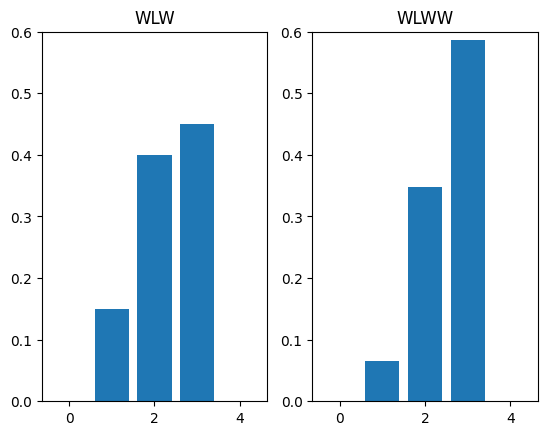

In [30]:
import matplotlib.pyplot as plt
import numpy as np

wlw = np.array([0, 3, 8, 9, 0])

wlw_norm = wlw / wlw.sum()

w = np.array([0, 1, 2, 3, 4])

wlww = wlw * w
wlww_norm = wlww / wlww.sum()

fig, axs = plt.subplots(1, 2)

axs[0].set_title("WLW")
axs[0].bar(x=range(len(wlw_norm)), height=wlw_norm)
axs[0].set_ylim(0, 0.6)
axs[1].set_title("WLWW")
axs[1].bar(x=range(len(wlww_norm)), height=wlww_norm)
axs[1].set_ylim(0, 0.6)

We work out that there is a formula for $W$ and $L$ in terms of $P$:

$$W,L = (4p)^{W} \times (4-4p)^{L}$$

### Testing

In [34]:
def sim_globe(p: float, N: int) -> np.array:
    return np.random.choice(a=["W", "L"], p=[p, 1 - p], size=N, replace=True)


sim_globe(p=0.25, N=9)

array(['W', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L'], dtype='<U1')

Do some tests!

In [43]:
sim_globe(p=1, N=9)

array(['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'], dtype='<U1')

In [44]:
sim_globe(p=0, N=9)

array(['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L'], dtype='<U1')

In [45]:
np.where(sim_globe(p=0.5, N=10_000) == "W", 1, 0).mean()

0.4995

In [70]:
def compute_posterior(sample, possibilities=[0, 0.25, 0.5, 0.75, 1]):

    W = (sample == "W").sum()
    L = (sample == "L").sum()

    estimator = lambda q: ((q * 4) ** W) * (((1 - q) * 4) ** L)

    ways = np.array(list(map(estimator, possibilities)))
    posterior = ways / ways.sum()
    return posterior


all(compute_posterior(np.array(["W", "L", "W"])) == wlw_norm)

True

In [71]:
all(compute_posterior(np.array(["W", "L", "W", "W"])) == wlww_norm)

True

## But the earth is a sphere not a tetrahedron...

$p^{W}(1-p)^{L}$

This isn't a probability dist so it needs to be normed, which ends up needing:
$$\frac{(W + L + 1)!}{W!L!}$$
WHich is the normalisign constant we get from the integral.

So we end up with:

$$\frac{(W + L + 1)!}{W!L!}p^{W}(1-p)^{L}$$

This is the beta distribution!

In [135]:
import arviz as az
import pymc as pm

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [probability]


/Users/henrysimmons/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-pymc-tvRae8FL-py3.11/lib/python3.11/
site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 8 chains for 500 tune and 4_000 draw iterations (4_000 + 32_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'probability'}>,
        <Axes: title={'center': 'probability'}>]], dtype=object)

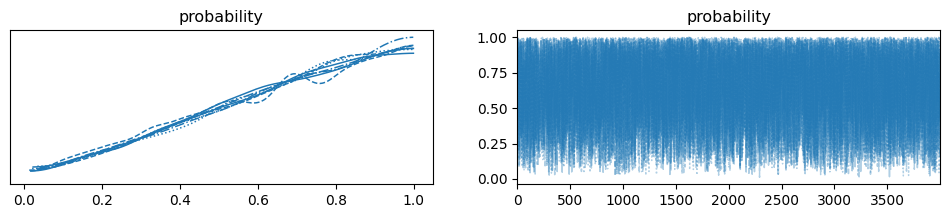

In [198]:
def model_maker(observed):
    with pm.Model() as model:
        probability = pm.Beta("probability", alpha=1, beta=1)
        observed = pm.Bernoulli("observed", p=probability, observed=observed)

    with model:
        trace = pm.sample(4000, tune=500, chains=8, cores=8)

    return az.plot_trace(trace)


model_maker([1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [probability]


/Users/henrysimmons/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-pymc-tvRae8FL-py3.11/lib/python3.11/
site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 8 chains for 500 tune and 4_000 draw iterations (4_000 + 32_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'probability'}>,
        <Axes: title={'center': 'probability'}>]], dtype=object)

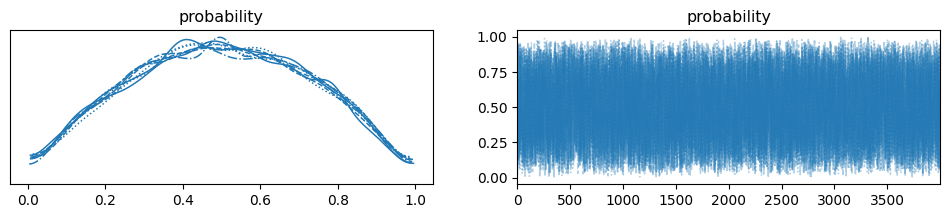

In [199]:
model_maker([1, 0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [probability]


/Users/henrysimmons/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-pymc-tvRae8FL-py3.11/lib/python3.11/
site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 8 chains for 500 tune and 4_000 draw iterations (4_000 + 32_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'probability'}>,
        <Axes: title={'center': 'probability'}>]], dtype=object)

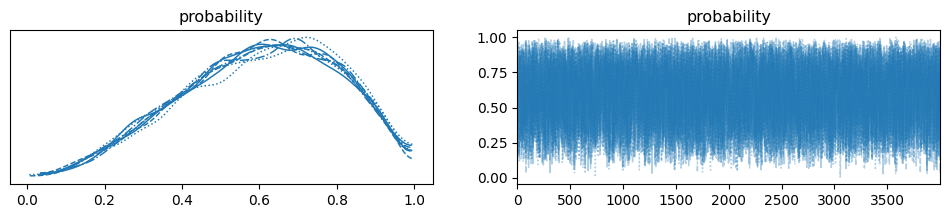

In [200]:
model_maker([1, 0, 1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [probability]


/Users/henrysimmons/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-pymc-tvRae8FL-py3.11/lib/python3.11/
site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 8 chains for 500 tune and 4_000 draw iterations (4_000 + 32_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'probability'}>,
        <Axes: title={'center': 'probability'}>]], dtype=object)

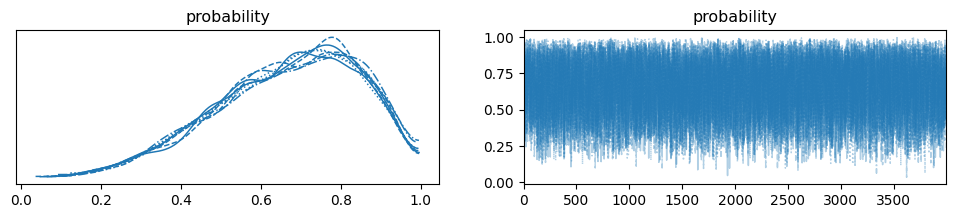

In [201]:
model_maker(
    [1, 0, 1, 1],
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [probability]


/Users/henrysimmons/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-pymc-tvRae8FL-py3.11/lib/python3.11/
site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 8 chains for 500 tune and 4_000 draw iterations (4_000 + 32_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'probability'}>,
        <Axes: title={'center': 'probability'}>]], dtype=object)

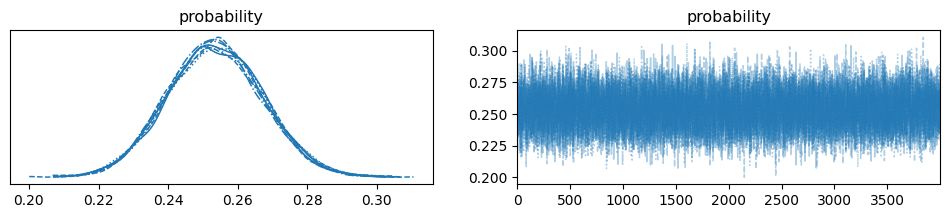

In [202]:
model_maker(np.random.choice([0, 1], p=[0.75, 0.25], size=1000))

## Homework

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [probability]


/Users/henrysimmons/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-pymc-tvRae8FL-py3.11/lib/python3.11/
site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 8 chains for 500 tune and 2_000 draw iterations (4_000 + 16_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'probability'}>,
        <Axes: title={'center': 'probability'}>]], dtype=object)

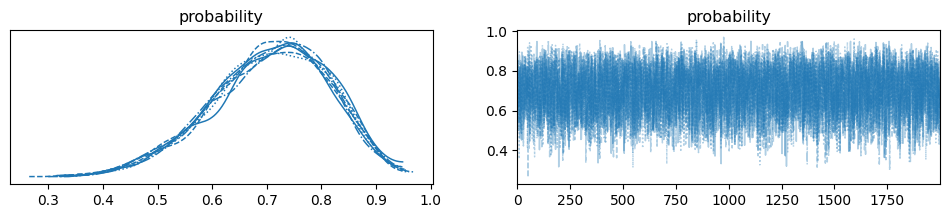

In [295]:
def encode_experiment(w: int, l: int):
    return [0.0 for i in range(w)] + [1.0 for i in range(l)]


with pm.Model() as model:
    probability = pm.Beta("probability", alpha=1, beta=1)

    data = pm.Data("data", encode_experiment(w=4, l=11))

    observed = pm.Bernoulli("observed", p=probability, observed=data)

with model:
    trace = pm.sample(2000, tune=500, chains=8, cores=8)

az.plot_trace(trace)

In [296]:
with model:
    pm.set_data({"data": [np.nan for i in range(5)]})
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [observed]


/Users/henrysimmons/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-pymc-tvRae8FL-py3.11/lib/python3.11/
site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/henrysimmons/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-pymc-tvRae8FL-py3.11/lib/python3.11/site-packages/pymc/pytensorf.py:156: RuntimeWarning: invalid value encountered in cast
  return array_data.astype(x.type.dtype)


In [297]:
1 - (ppc.posterior_predictive["observed"].sum("observed_dim_2") >= 3).mean()

<xarray.DataArray 'observed' ()> Size: 8B
array(0.1823125)